# DataMole Case Study

Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine Ė i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable.

## Initial thoughts

In terms of RUL, this can be approached as time-series forecast problem (as opposed to anomaly-type problem).

Dimensional reduction (such as PCA, t-SNE, UMAP) can be considered and feature scaling might be required.
The most intiutive way would be to use LSTM as a base model and compare those results to other ML models such as XGBoost. Another option would be to convert the time-series into images and use CNN.

Our main evaluation metrics might include Coefficient of Detrmination (Rˆ2), (R)MSE, Confusion Matrix, Precision-Recall Curve.

# Libraries

In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tools
from sklearn.preprocessing import StandardScaler

# Model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Defaults
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.max_columns = None

# Load Data

In [2]:
colnames = ['unit', 'cycles', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9',
            'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21']

In [3]:
train1 = pd.read_csv('train_FD001.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
train1.shape

(20631, 25)

In [4]:
train2 = pd.read_csv('train_FD002.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
train2.shape

(53759, 25)

In [5]:
train3 = pd.read_csv('train_FD003.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
train3.shape

(24720, 25)

In [6]:
train4 = pd.read_csv('train_FD004.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
train4.shape

(61249, 25)

In [7]:
test1 = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
test1.shape

(13096, 25)

In [8]:
test2 = pd.read_csv('test_FD002.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
test2.shape

(33991, 25)

In [9]:
test3 = pd.read_csv('test_FD003.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
test3.shape

(16596, 25)

In [10]:
test4 = pd.read_csv('test_FD004.txt', delim_whitespace=True, names=colnames, header=None, index_col=[0])
test4.shape

(41214, 25)

In [11]:
eval1 = pd.read_csv('RUL_FD001.txt', delim_whitespace=True, header=None)
eval1.shape

(100, 1)

In [12]:
eval2 = pd.read_csv('RUL_FD002.txt', delim_whitespace=True, header=None)
eval2.shape

(259, 1)

In [13]:
eval3 = pd.read_csv('RUL_FD003.txt', delim_whitespace=True, header=None)
eval3.shape

(100, 1)

In [14]:
eval4 = pd.read_csv('RUL_FD004.txt', delim_whitespace=True, header=None)
eval4.shape

(248, 1)

In [15]:
# Check
train1.head()

cycles     os1     os2    os3     sm1     sm2      sm3      sm4    sm5  \
unit                                                                           
1          1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1          2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
1          3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
1          4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
1          5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

        sm6     sm7      sm8      sm9  sm10   sm11    sm12     sm13     sm14  \
unit                                                                           
1     21.61  554.36  2388.06  9046.19   1.3  47.47  521.66  2388.02  8138.62   
1     21.61  553.75  2388.04  9044.07   1.3  47.49  522.28  2388.07  8131.49   
1     21.61  554.26  2388.08  9052.94   1.3  47.27  522.42  2388.03  8133.23   
1     21.61  554.45  2388.11  9049.48   1.3  47.13  522.86  2388.08  8133.83   
1     21.61  554.00  2388.06  9055.15   1.3  47.28  522.19  2388.04  8133.80   

        sm15  sm16  sm17  sm18   sm19   sm20     sm21  
unit                                                   
1     8.4195  0.03   392  2388  100.0  39.06  23.4190  
1     8.4318  0.03   392  2388  100.0  39.00  23.4236  
1     8.4178  0.03   390  2388  100.0  38.95  23.3442  
1     8.3682  0.03   392  2388  100.0  38.88  23.3739  
1     8.4294  0.03   393  2388  100.0  38.90  23.4044

In [16]:
# Check number of time series (no. of engines)
len(train1.index.unique())

100

There're two ways now what to do with the datasets, assuming they're all the same type of engine under different (testing) conditions:
1) DFs can me merged together
2) Models can be blended together

However, without futher informations provided about the type of an engine, it can't be done otherwise but to choose just one train/test dataset pair to develop a model.

# Data Exploration

In [17]:
train1.describe()

cycles           os1           os2      os3           sm1  \
count  20631.000000  20631.000000  20631.000000  20631.0  2.063100e+04   
mean     108.807862     -0.000009      0.000002    100.0  5.186700e+02   
std       68.880990      0.002187      0.000293      0.0  6.537152e-11   
min        1.000000     -0.008700     -0.000600    100.0  5.186700e+02   
25%       52.000000     -0.001500     -0.000200    100.0  5.186700e+02   
50%      104.000000      0.000000      0.000000    100.0  5.186700e+02   
75%      156.000000      0.001500      0.000300    100.0  5.186700e+02   
max      362.000000      0.008700      0.000600    100.0  5.186700e+02   

                sm2           sm3           sm4           sm5           sm6  \
count  20631.000000  20631.000000  20631.000000  2.063100e+04  20631.000000   
mean     642.680934   1590.523119   1408.933782  1.462000e+01     21.609803   
std        0.500053      6.131150      9.000605  3.394700e-12      0.001389   
min      641.210000   1571.040000   1382.250000  1.462000e+01     21.600000   
25%      642.325000   1586.260000   1402.360000  1.462000e+01     21.610000   
50%      642.640000   1590.100000   1408.040000  1.462000e+01     21.610000   
75%      643.000000   1594.380000   1414.555000  1.462000e+01     21.610000   
max      644.530000   1616.910000   1441.490000  1.462000e+01     21.610000   

                sm7           sm8           sm9          sm10          sm11  \
count  20631.000000  20631.000000  20631.000000  2.063100e+04  20631.000000   
mean     553.367711   2388.096652   9065.242941  1.300000e+00     47.541168   
std        0.885092      0.070985     22.082880  4.660829e-13      0.267087   
min      549.850000   2387.900000   9021.730000  1.300000e+00     46.850000   
25%      552.810000   2388.050000   9053.100000  1.300000e+00     47.350000   
50%      553.440000   2388.090000   9060.660000  1.300000e+00     47.510000   
75%      554.010000   2388.140000   9069.420000  1.300000e+00     47.700000   
max      556.060000   2388.560000   9244.590000  1.300000e+00     48.530000   

               sm12          sm13          sm14          sm15          sm16  \
count  20631.000000  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean     521.413470   2388.096152   8143.752722      8.442146  3.000000e-02   
std        0.737553      0.071919     19.076176      0.037505  1.556432e-14   
min      518.690000   2387.880000   8099.940000      8.324900  3.000000e-02   
25%      520.960000   2388.040000   8133.245000      8.414900  3.000000e-02   
50%      521.480000   2388.090000   8140.540000      8.438900  3.000000e-02   
75%      521.950000   2388.140000   8148.310000      8.465600  3.000000e-02   
max      523.380000   2388.560000   8293.720000      8.584800  3.000000e-02   

               sm17     sm18     sm19          sm20          sm21  
count  20631.000000  20631.0  20631.0  20631.000000  20631.000000  
mean     393.210654   2388.0    100.0     38.816271     23.289705  
std        1.548763      0.0      0.0      0.180746      0.108251  
min      388.000000   2388.0    100.0     38.140000     22.894200  
25%      392.000000   2388.0    100.0     38.700000     23.221800  
50%      393.000000   2388.0    100.0     38.830000     23.297900  
75%      394.000000   2388.0    100.0     38.950000     23.366800  
max      400.000000   2388.0    100.0     39.430000     23.618400

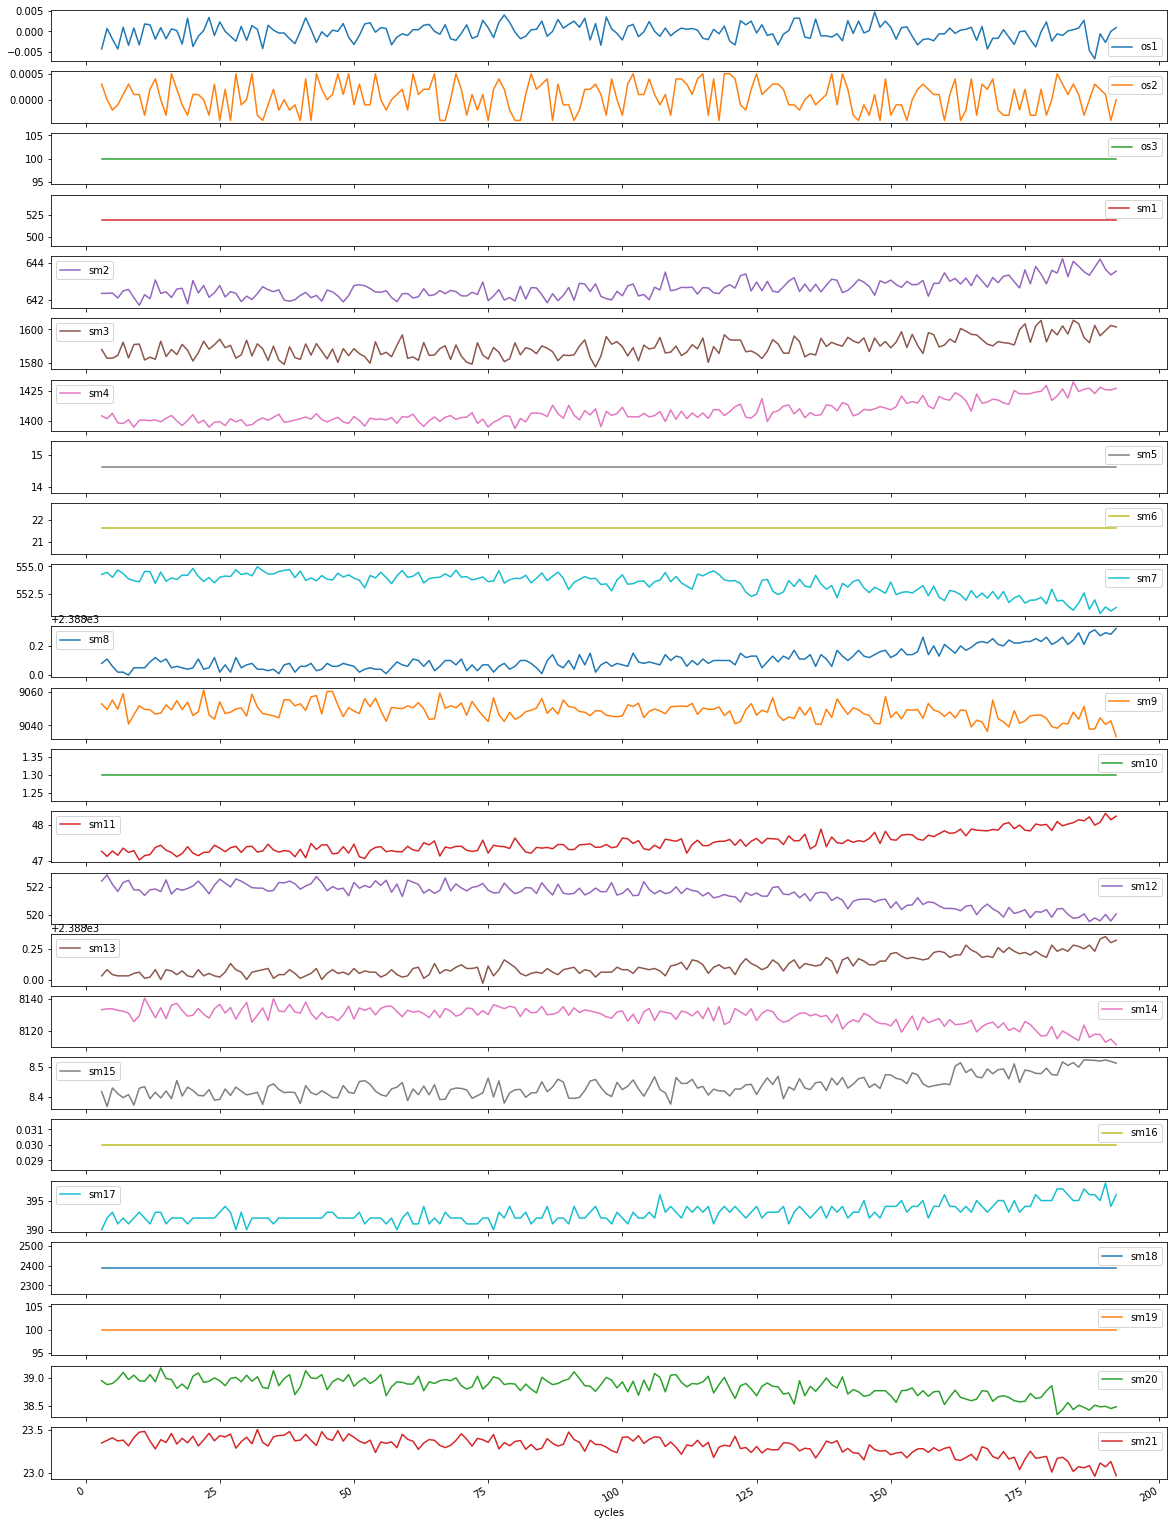

In [18]:
# Invidual characteristics of engine no. 1
eng = train1[train1.index==1]
ax = eng[2:].plot(x='cycles', subplots=True, figsize=(20, 30))

In [19]:
#TODO: Calculate vectors of failure

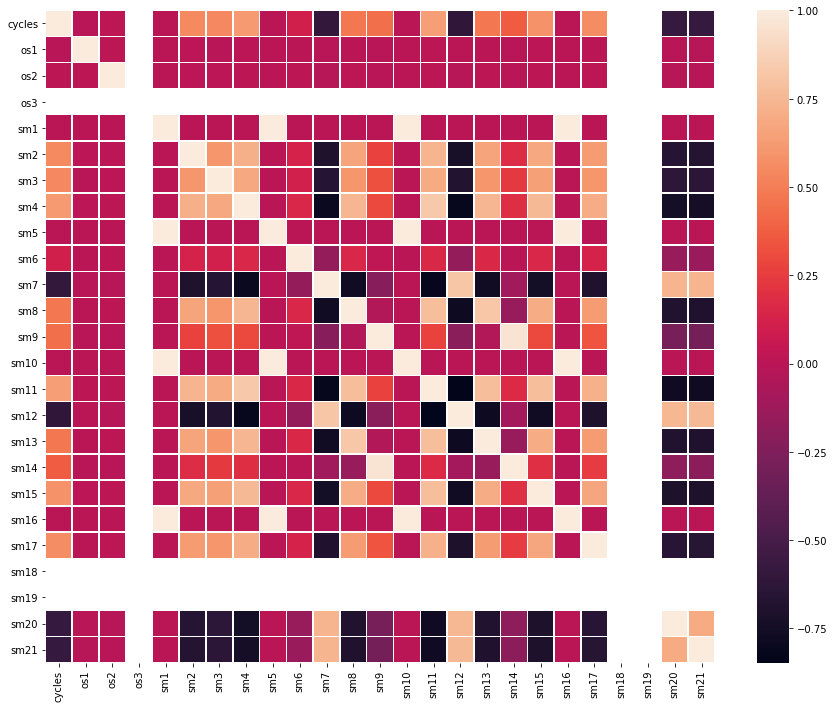

In [20]:
# Correlation matrix
corr = train1.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, linewidths=.5)

# Data Pre-processing

In [21]:
# Concat training and testing dataset together
split = len(train1) #split marker
data =  pd.concat(objs=[train1, test1], axis=0) #If something's goes wrong, it's here (index)
data.shape

(33727, 25)

In [22]:
# Drop columns with no relevant informations
to_drop = ['os3', 'sm1', 'sm5', 'sm10', 'sm16', 'sm18', 'sm19']
data = data.drop(to_drop, axis=1)

In [23]:
#TODO: exponential smoothing (sensor noise)

Should we use RobustScaler or StandardScaler? Does an outlier forecast a possible malfunction in the future or it's just a sensor noise? I'm operating here with the first scenario, thus choosing StandardScaler.
I'm not using Normalization because I hypothetise it's more relevant how much the readings differs TILL failure.

In [24]:
# Scale features
sc = StandardScaler()

data.iloc[:, 1:] = sc.fit_transform(data.iloc[:, 1:])

In [25]:
# Split data
train_df = data[:split]
test_df = data[split:]

In [27]:
# Add target
train_df['RUL']=train_df.groupby(train_df.index)['cycles'].transform(max)-train_df['cycles'] # RUL is an inverse function of cycles

# Model

The most intutive way would be to use LSTM.

In [30]:
# Get variables for a model
X_train = train_df.drop(["RUL"], axis=1)
y_train = train_df["RUL"]

print(X_train.shape)
print(y_train.shape)

(20631, 18)
(20631,)


In [31]:
# Remove header for the generator
X_train.to_csv('X_train.csv', header=None)
y_train.to_csv('y_train.csv', header=None)

X = pd.read_csv('X_train.csv', header=None, index_col=[0])
y = pd.read_csv('y_train.csv', header=None, index_col=None)

In [ ]:
# Timeseries Generator
'''
data_gen = TimeseriesGenerator(X, y,
                               length=18, sampling_rate=1,
                               batch_size=2)
'''

We have 100 engines within our dataset, thus we need to write a generator function here to append those sequences into an array.

In [ ]:
# Timeseries Generator
for unit in train_df.index.unique():
    train_gen.append(TimeseriesGenerator(X[X.index==unit], y[y.index==unit],
                               length=18, sampling_rate=1,
                               batch_size=2))
    
train_gen = np.asarray(train_gen)
                                                 
print("X_train shape (gen):", train_gen.shape)

In [ ]:
#TODO: Generator function

In [ ]:
# Model
model = Sequential()
model.add(LSTM(units=128, activation='relu', dropout=0.25, input_shape=(10,1))) # Input layer
model.add(Dense(units=1)) # Output layer
model.compile(optimizer='adam', loss='rmae')
#model.fit(X_train, y_train, epochs=30, batch_size=7)
model.fit_generator(data_gen, steps_per_epoch=len(data_gen), epochs=100)

# Evaluation

Here I'd compare the results from testing dataset on evaluation (ground truth) dataset provided (RUL).

In [ ]:
# Rˆ2, RMSE

In [ ]:
# Confusion Matrix

In [ ]:
# Precision-Recall Curve

# Appendix

In [ ]:
Similar Kaggle projects:
    
https://www.kaggle.com/jirakst/credit-card-fraud-detection
https://www.kaggle.com/jirakst/ieee-fraud-detection
https://www.kaggle.com/jirakst/bitcoin-prediction-with-lstm

GitHub: https://github.com/jirakst

Chat-bot (Telegram): @stanbot_bot